# Replication of Acute Clinical Deterioration study using Salford dataset

In [1]:
cd ..

c:\Users\stybl\src\acute-care-pathways


In [3]:
import warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
from IPython.display import display

%load_ext autoreload
%autoreload 1
%aimport datasets.salford, acd_experiment.utils.salford_dataset_replication

from datasets.salford import SalfordData, SalfordFeatures
from acd_experiment.utils.salford_dataset_replication import plot_confusion_matrix

class Notebook:
    DATA_DIR = 'data/Salford'
    FROM_EXCEL = False

In [4]:
sal = SalfordData(pd.read_hdf(f'{Notebook.DATA_DIR}/sal_processed.h5', 'table'))

## Overlap with SCI Dataset

In [5]:
from acd_experiment.sci import SCIData, SCICols

scii = (
    SCIData(
        SCIData.quickload("data/SCI/sci_processed.h5").sort_values(
            "AdmissionDateTime"
        )
    )
    .mandate(SCICols.news_data_raw)
    .derive_ae_diagnosis_stems(onehot=False)
    .derive_critical_event(return_subcols=True, within=1)
    .set_index('SpellSerial')
)
sci_sal_intersect = np.intersect1d(sal.index, scii.index)

Common entries: 120704/121279 = 99.53% overlap.
Overlap is 120704/401452 = 30.07% of Salford data.


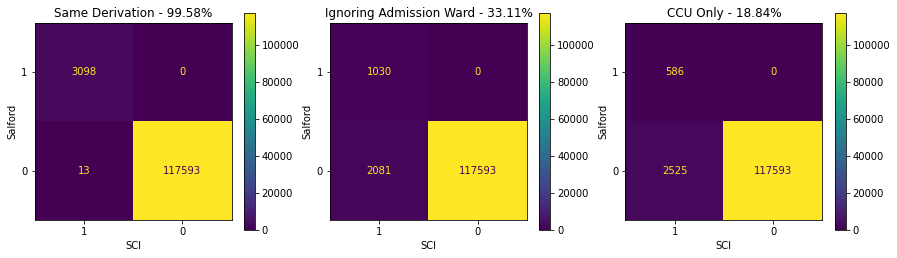

In [11]:
print(f'Common entries: {sci_sal_intersect.shape[0]}/{scii.shape[0]} = {sci_sal_intersect.shape[0]/scii.shape[0]*100:.2f}% overlap.')
print(f'Overlap is {sci_sal_intersect.shape[0]}/{sal.shape[0]} = {sci_sal_intersect.shape[0]/sal.shape[0]*100:.2f}% of Salford data.')

def compare_labels(sal, scii):
    salford_labels = {
        'Same Derivation': sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=False, return_series=True),
        'Ignoring Admission Ward': sal.derive_critical_event(wards=["CCU", "HH1M"], return_series=True),
        'CCU Only': sal.derive_critical_event(wards=["CCU"], ignore_admit_ward=True, return_series=True)
    }

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for i, (title, y_sal) in enumerate(salford_labels.items()):
        y_scii, y_sal = scii.CriticalEvent.loc[sci_sal_intersect], y_sal.loc[sci_sal_intersect]
        title = f'{title} - {(y_scii & y_sal).sum()/y_scii.sum()*100:.2f}%'
        plot_confusion_matrix(y_scii, y_sal, ax=ax[i], plot_title=title, normalize=None, xlabel='SCI', ylabel='Salford')

compare_labels(sal, scii)


## Predicting Deterioration

### LightGBM

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, fbeta_score, make_scorer

calibration_parameters = dict(
    ensemble=True,
    cv=3,
    method='isotonic',
    n_jobs=3
)

cross_validation_metrics = dict(
    Precision='precision',
    Recall='recall',
    AUC='roc_auc',
    AP='average_precision',
    F2=make_scorer(fbeta_score, beta=2)
)

In [10]:
import itertools
from lightgbm import LGBMClassifier
from tqdm import tqdm

RESULTS = []
def old_study_replication(sal, sci_sal_intersect):
    scores_with_notes_labs_and_hospital = ['NEWS_RespiratoryRate_Admission', 'NEWS_O2Sat_Admission', 'NEWS_Temperature_Admission', 'NEWS_BP_Admission', 'NEWS_HeartRate_Admission', 'NEWS_AVCPU_Admission', 'NEWS_BreathingDevice_Admission', 'Female', 'Age', 'Blood_Haemoglobin_Admission', 'Blood_Urea_Admission', 'Blood_Sodium_Admission', 'Blood_Potassium_Admission', 'Blood_Creatinine_Admission', 'AE_PresentingComplaint', 'AE_MainDiagnosis', 'SentToSDEC', 'Readmission', 'AdmitMethod', 'AdmissionSpecialty']
    new_features = ['Blood_DDimer_Admission', 'Blood_CRP_Admission', 'Blood_Albumin_Admission', 'Blood_WhiteCount_Admission', 'Waterlow_Score', 'CFS_Score', 'CharlsonIndex']
    
    X = SalfordData(sal[scores_with_notes_labs_and_hospital + new_features]).convert_str_to_categorical(inplace=False)
    outcomes = {
        "4 Strict Labelling": sal.derive_critical_event(wards=["CCU"], ignore_admit_ward=True, return_series=True),
        "3 H1 but no direct admissions": sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=True, return_series=True),
        "2 Direct admissions but no H1": sal.derive_critical_event(wards=["CCU"], ignore_admit_ward=False, return_series=True),
        "1 SCI Labelling": sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=False, return_series=True)
    }
    feature_sets = {
        "1 SCI Features": scores_with_notes_labs_and_hospital,
        "2 SCI Features (No Adm. Specialty)": scores_with_notes_labs_and_hospital[:-1],
        "3 New Features": scores_with_notes_labs_and_hospital + new_features,
        "4 New Features (No Adm. Speciality)": scores_with_notes_labs_and_hospital[:-1] + new_features
    }
    record_sets = {
        "1 SCI Records": sci_sal_intersect,
        "2 All Records": X.index
    }

    lightgbm_parameters = dict(
        objective='binary',
        random_state=42,
        metrics=['l2', 'auc'],
        boosting_type='gbdt',
        n_jobs=1,
        is_unbalance=True
    )

    for i, ((y_name, y), (x_name, x), (xi_name, xi)) in tqdm(enumerate(itertools.product(outcomes.items(), feature_sets.items(), record_sets.items()))):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            RESULTS.append(
                pd.DataFrame.from_dict(cross_validate(CalibratedClassifierCV(
                    LGBMClassifier(**lightgbm_parameters), **calibration_parameters
                ), X.loc[xi, x], y.loc[xi], cv=5, n_jobs=1, scoring=cross_validation_metrics)).assign(
                    Iter=i,
                    Features=x_name,
                    Records=xi_name,
                    Outcomes=y_name
                )
            )

    return RESULTS

sal = SalfordData(sal[sal.Age >= 16])
replication_results = pd.concat(old_study_replication(sal, sci_sal_intersect)).drop('Iter', axis=1).groupby(['Records', 'Features', 'Outcomes']).mean()
replication_results

fit_time  \
Records       Features                            Outcomes                                  
1 SCI Records 1 SCI Features                      1 SCI Labelling                2.356072   
                                                  2 Direct admissions but no H1  2.112926   
                                                  3 H1 but no direct admissions  2.354774   
                                                  4 Strict Labelling             2.748342   
              2 SCI Features (No Adm. Specialty)  1 SCI Labelling                2.289584   
                                                  2 Direct admissions but no H1  2.042504   
                                                  3 H1 but no direct admissions  2.263024   
                                                  4 Strict Labelling             2.130139   
              3 New Features                      1 SCI Labelling                2.830523   
                                                  2 Direct admissions but no H1  2.471237   
                                                  3 H1 but no direct admissions  2.821882   
                                                  4 Strict Labelling             2.546856   
              4 New Features (No Adm. Speciality) 1 SCI Labelling                2.668506   
                                                  2 Direct admissions but no H1  2.430592   
                                                  3 H1 but no direct admissions  2.766000   
                                                  4 Strict Labelling             2.521517   
2 All Records 1 SCI Features                      1 SCI Labelling                7.668597   
                                                  2 Direct admissions but no H1  7.357902   
                                                  3 H1 but no direct admissions  7.075823   
                                                  4 Strict Labelling             6.894942   
              2 SCI Features (No Adm. Specialty)  1 SCI Labelling                7.261368   
                                                  2 Direct admissions but no H1  6.978078   
                                                  3 H1 but no direct admissions  6.688806   
                                                  4 Strict Labelling             6.692991   
              3 New Features                      1 SCI Labelling                8.836893   
                                                  2 Direct admissions but no H1  8.556769   
                                                  3 H1 but no direct admissions  8.135735   
                                                  4 Strict Labelling             8.276858   
              4 New Features (No Adm. Speciality) 1 SCI Labelling                8.584045   
                                                  2 Direct admissions but no H1  8.326641   
                                                  3 H1 but no direct admissions  7.893002   
                                                  4 Strict Labelling             7.854054   

                                                                                 score_time  \
Records       Features                            Outcomes                                    
1 SCI Records 1 SCI Features                      1 SCI Labelling                  0.974749   
                                                  2 Direct admissions but no H1    0.787281   
                                                  3 H1 but no direct admissions    0.955999   
                                                  4 Strict Labelling               0.761611   
              2 SCI Features (No Adm. Specialty)  1 SCI Labelling                  0.909587   
                                                  2 Direct admissions but no H1    0.743578   
                                                  3 H1 but no direct admissions    0.910724   
                                                  4 Strict Labe

### Logistic Regression

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

sal_X = SalfordData(
    sal.loc[sci_sal_intersect, scores_with_notes_labs_and_hospital]
).convert_str_to_categorical(inplace=False)
sal_y = sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=False, return_series=True).loc[sci_sal_intersect]

lr_transformer = make_column_transformer(
    (make_pipeline(StandardScaler(), SimpleImputer(strategy='median')), make_column_selector(dtype_include=np.number)),
    (make_pipeline(OneHotEncoder(), SimpleImputer(strategy='constant', fill_value=0)), make_column_selector(dtype_include='category')),
    (make_pipeline(OneHotEncoder(drop='if_binary'), SimpleImputer(strategy='most_frequent')), make_column_selector(dtype_include='bool')),
    remainder=SimpleImputer(strategy='constant', fill_value=0)
)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_parameters = dict(
    LR=dict(
        max_iter=500,
        solver="lbfgs",
        random_state=42,
        penalty='none'
    ),
    L1=dict(
        max_iter=500,
        solver="saga",
        random_state=42,
        penalty='l1'
    ),
    L2=dict(
        max_iter=500,
        solver="lbfgs",
        random_state=42,
        penalty='l2'
    ),
    EN=dict(
        max_iter=500,
        solver="saga",
        random_state=42,
        penalty='elasticnet',
        l1_ratio=0.5
    ),
)

pd.concat(
    pd.DataFrame.from_dict(cross_validate(CalibratedClassifierCV(
        LogisticRegression(**parameters), **calibration_parameters
    ), lr_transformer.fit_transform(sal_X), sal_y, cv=5, n_jobs=1, scoring=cross_validation_metrics)).assign(model=modelname)
    for modelname, parameters in lr_parameters.items()
).groupby('model').mean()